PART 2: Unsupervised learning with topic modeling, word and document embeddings.

We'll use the following packages:
-Gensim
-Sklearn

We'll take preprocessed data from PART 1, which we load here from pickle file.

For full tutorials, see
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
https://radimrehurek.com/gensim/auto_examples/index.html


In [1]:
# root folder of data
DATA_ROOT = r'D:\Downloads\NLP_introduction-20191023T064334Z-001\NLP_introduction' + r'\\'

# load our preprocessed data
import pickle
data=pickle.load(open(DATA_ROOT + 'turkuNLP_preprocessed_data.pickle','rb'))
real_labels = [x['label'] for x in data]

First we create new list of documents that we use.

In [2]:
# We use lemmas and replace numbers and proper nouns, which might improve results.
docs = []
for sample in data:
    tokens = []
    for k,lemma in enumerate(sample['tokens_lemma']):
        if sample['tokens_pos']=='NUM' or lemma.isdigit():
            tokens.append('NUMERO')
        elif sample['tokens_pos']=='PROPN':
            tokens.append('ERISNIMI')
        else:
            tokens.append(lemma)        
    docs.append(tokens)    

We train our own word2vec and fasttext word embeddings, which are the basic type of embeddings.

For details, see:
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
https://radimrehurek.com/gensim/auto_examples/tutorials/run_fasttext.html

In [3]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html
import gensim.models

# train word2vec model for tokens
print('Training word2vec')
word2vec_model = gensim.models.Word2Vec(sentences=docs,min_count=5,size=50)
print('Word2vec vector for "raha":\n%s' % str(word2vec_model.wv["raha"]))

fasttext_model = gensim.models.FastText(size=50, window=3, min_count=2)
# build the vocabulary
fasttext_model.build_vocab(docs)
# train the model
print('Training Fasttext')
fasttext_model.train(sentences=docs, epochs=10,total_examples=fasttext_model.corpus_count, total_words=fasttext_model.corpus_total_words)
print('Fasttext vector for "raha":\n%s' % str(fasttext_model.wv["raha"]))

Training word2vec
Word2vec vector for "raha":
[-1.758409    0.86426073  0.04811103 -0.1492375  -1.3663752   0.11534894
 -0.52196044 -0.41687492  0.57166153  0.95367944 -0.5265347  -0.05917316
  1.1319683   0.11974289  0.18481076 -0.26625633  0.4351805  -0.06553287
  0.5351881   0.8834069   0.45812955 -0.7701423  -0.25638494 -0.7032677
  0.45109108 -0.17157598 -0.3715253  -0.4092941   0.26017982 -0.32259172
  0.19189987  0.25004682  0.04834657 -0.72324    -0.25672758  0.20667277
 -0.2651854  -0.4614902   0.17878667 -0.29419586 -0.3443773   0.04885345
  0.12388042 -0.1327765   0.21701157  0.4596571  -0.15812466 -0.8252365
  0.25564426 -0.2207362 ]
Training Fasttext
Fasttext vector for "raha":
[-0.17558005  0.93536204 -0.54447097  0.823514    0.09879616  0.2516961
  0.30965576  0.7252012   0.05519624  0.16473831 -0.78389436  0.20160884
  0.23904632  0.5061487  -0.13430321  0.09138744 -0.6289764   0.04521519
 -0.03385026 -0.26525185  0.1478592  -0.19736208 -0.9794943   0.9949135
 -1.675547

We can also get simple embeddings for all words in a document using doc2vec.

https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

In [4]:
import gensim.models
# initialize the doc2vec model
doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40,seed=1)
# create tagged corpus
tagged_docs = [gensim.models.doc2vec.TaggedDocument(x, [i]) for i,x in enumerate(docs)]
# build vocabulary
doc2vec_model.build_vocab(tagged_docs)
# train the model
print('Training doc2vec')
doc2vec_model.train(tagged_docs,total_examples=doc2vec_model.corpus_count,epochs=doc2vec_model.epochs)

# get vectors for our documents
doc_vectors = [doc2vec_model.infer_vector(x) for x in docs]
# vector of first document
print("vector of the first document\n%s" % str(doc_vectors[0]))

Training doc2vec
vector of the first document
[-0.08774439  0.03857881 -0.13961174  0.12768424 -0.9330203  -0.9197342
 -0.5347553  -0.8088072  -0.2964947   0.34486282 -0.5083449  -0.442461
  0.6277515   1.2498709   0.15605663 -0.58907586 -0.28063324  0.5042412
 -0.22362247  1.1449949  -0.0144661  -1.1428658   0.62796044  0.14786983
  1.0415618  -0.12175384  0.50732315 -0.33486807 -0.93431157  0.44135308
 -0.03392299 -0.15346119  0.44909313  0.4541287  -1.6938128  -0.31278306
  0.3560804   0.00193401  0.54678994  0.51129407 -0.6105897  -0.1847769
  1.0075984   0.19444893  0.13239272 -1.0686628  -0.17022564 -1.2122276
  0.3190169  -0.10360125]


Plotting document vectors


<IPython.core.display.Javascript object>


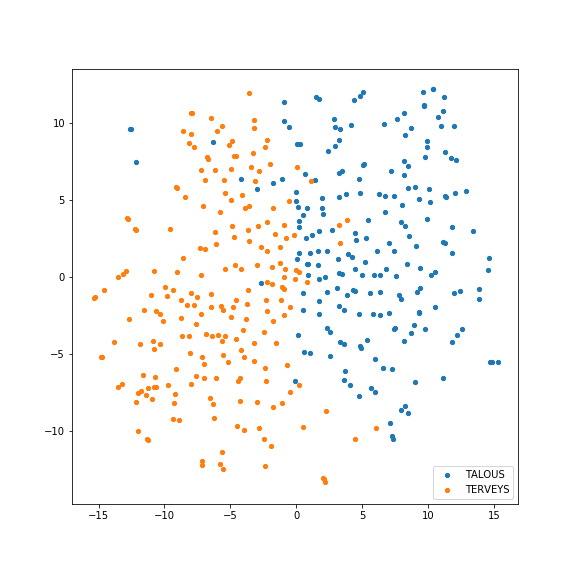

In [5]:
# visualize document embeddings with t-SNE
from sklearn.manifold import TSNE # final reduction
import numpy as np # array handling

def reduce_dimensions(X):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)
    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(X)
    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return np.array(x_vals), np.array(y_vals)

# get 2D embeddings for each document
x_vals, y_vals = reduce_dimensions(doc_vectors)

print('Plotting document vectors')
%matplotlib notebook
from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
for label in np.unique(real_labels):
    ind=np.where(np.array(real_labels)==label)[0]
    plt.scatter(x_vals[ind], y_vals[ind],s=18,label=label)
plt.legend(loc='lower right')
plt.show()

As you seeDocuments are nicely separated (even linearly) by their label despite the fact that we're using unsupervised model that has no knowledge of actual labels.
We could use these vectors to build a good classifier.

Finally, we do Latent Diriclet Allocation (LDA) topic modeling. This state of art model for traditional (non-neural) topic modeling.

Topic modeling can be easily compared to clustering. As in the case of clustering, the number of topics, like the number of clusters, is a hyperparameter. By doing topic modeling we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a certain weight.

Wikipedia: "LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model."

In [6]:
import copy
docs_expanded = copy.deepcopy(docs) # create a copy

from gensim.models import Phrases
# Add bigrams and trigrams to docs
bigram = Phrases(docs_expanded)
for idx in range(len(docs_expanded)):
    for token in bigram[docs_expanded[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs_expanded[idx].append(token)

from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs_expanded)

# Filter out words that occur less than 2 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=2, no_above=0.50)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs_expanded]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

from gensim.models import LdaModel

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

# now we train the LDA model
print('Training LDA model')
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=2,passes=40,alpha='auto',eta='auto',iterations = 500,random_state=0)

# print top words and weights 
top_words = lda_model.print_topics(num_topics=2,num_words=15)
for topic in top_words:
    print('Topic %i top terms:' % topic[0])
    for k,word in enumerate(topic[1].split(' + ')):
        print('  %i: %s' % (k+1,word))

# get most probable topic for each sample
inferred_labels = [lda_model[x][0][0] for x in corpus]
# attach label (which we know here)
inferred_labels = ['TERVEYS' if x==0 else 'TALOUS' for x in inferred_labels]
# compute accuracy
accuracy = (sum([inferred_labels[k]==real_labels[k] for k in range(len(real_labels))])/len(real_labels))
# in case topics were flipped, take the better one
accuracy = max(accuracy,1-accuracy)

print('Accuracy of topic labels against the real labels was %f' % accuracy )

Number of unique tokens: 5205
Number of documents: 416
Training LDA model
Topic 0 top terms:
  1: 0.011*"ei"
  2: 0.010*"""
  3: 0.008*"hoito"
  4: 0.008*"lääke"
  5: 0.007*"että"
  6: 0.006*"tämä"
  7: 0.006*"potilas"
  8: 0.006*"vuosi"
  9: 0.006*"‚"
  10: 0.005*"masennus"
  11: 0.005*",_että"
  12: 0.005*"sekä"
  13: 0.005*"tutkimus"
  14: 0.005*"käyttö"
  15: 0.005*"esimerkiksi"
Topic 1 top terms:
  1: 0.015*"""
  2: 0.009*"ei"
  3: 0.008*"että"
  4: 0.007*"tämä"
  5: 0.007*",_että"
  6: 0.007*"raha"
  7: 0.007*"vuosi"
  8: 0.006*"Suomi"
  9: 0.006*"saada"
  10: 0.006*"esimerkiksi"
  11: 0.005*"yritys"
  12: 0.005*"mukaan"
  13: 0.005*"vuosi_NUMERO"
  14: 0.004*"arvo"
  15: 0.004*"tarkoittaa"
Accuracy of topic labels against the real labels was 0.944712
